First few rows of the dataset:
   trial     file_name      method    material size  faraday_charge_pC_before  \
0      1  digNylonBig1  usb plasma  nylon ball  big                     305.5   
1      2  digNylonBig1  usb plasma  nylon ball  big                     204.8   
2      3  digNylonBig1  usb plasma  nylon ball  big                     182.6   
3      4  digNylonBig1  usb plasma  nylon ball  big                     256.8   
4      5  digNylonBig1  usb plasma  nylon ball  big                     191.4   

   faraday_charge_pC_after  
0                    54.38  
1                    25.15  
2                    13.86  
3                    18.66  
4                    26.91  
Summary statistics for Faraday Charge (pC) before and after:
       faraday_charge_pC_before  faraday_charge_pC_after
count                 40.000000                40.000000
mean                  56.312200                13.169950
std                  122.174171                53.145397
min                

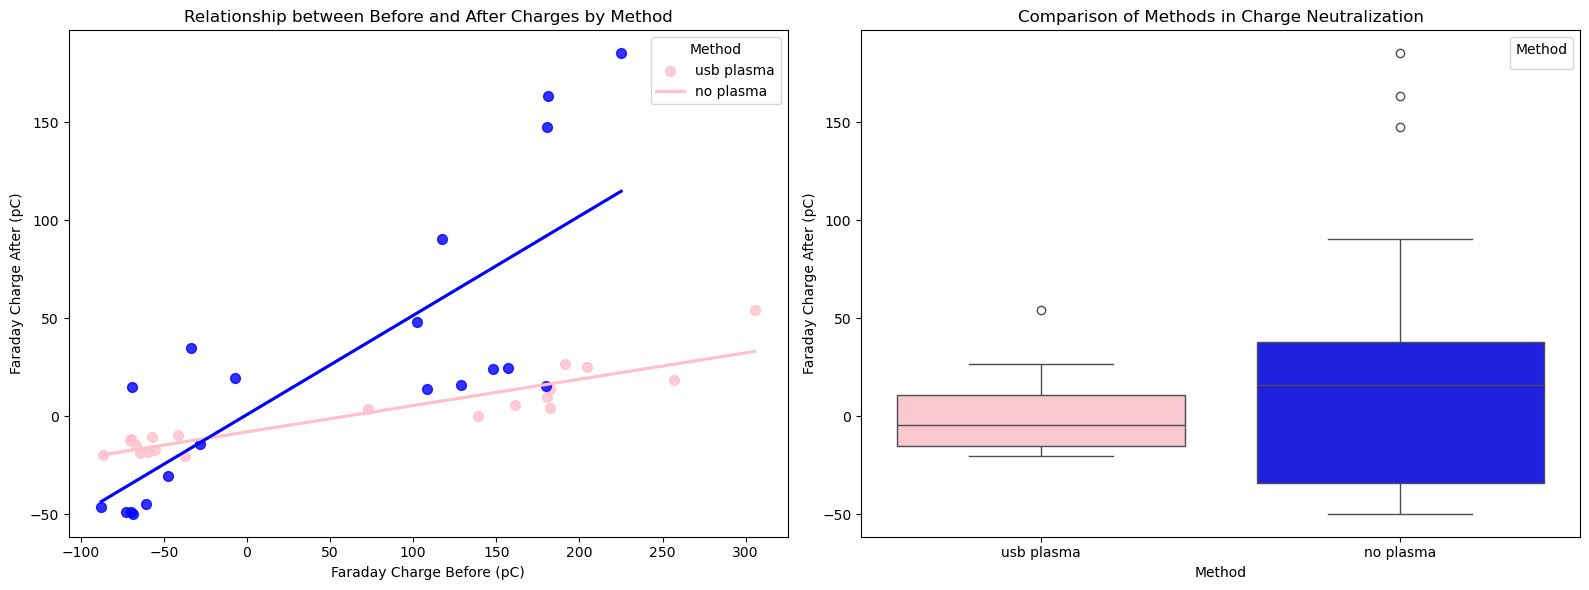

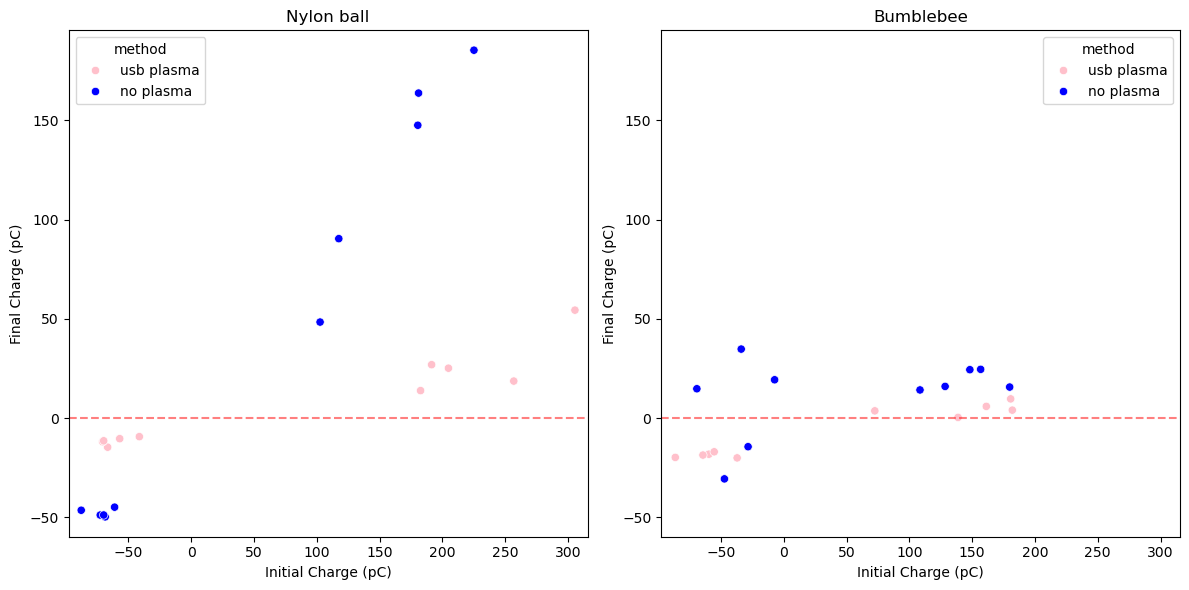

Summary of size effect on charge changes:
    size      method  mean_faraday_change  sd_faraday_change   n
0    big   no plasma                73.00              68.32  10
1    big  usb plasma                16.26              16.22  10
2  small   no plasma               -21.47              32.89  10
3  small  usb plasma               -15.12               4.10  10
Summary of material effect on charge changes:
     material      method  mean_faraday_change  sd_faraday_change   n
0   bumblebee   no plasma                11.86              19.54  10
1   bumblebee  usb plasma                -6.99              12.59  10
2  nylon ball   no plasma                39.67              99.48  10
3  nylon ball  usb plasma                 8.13              23.27  10


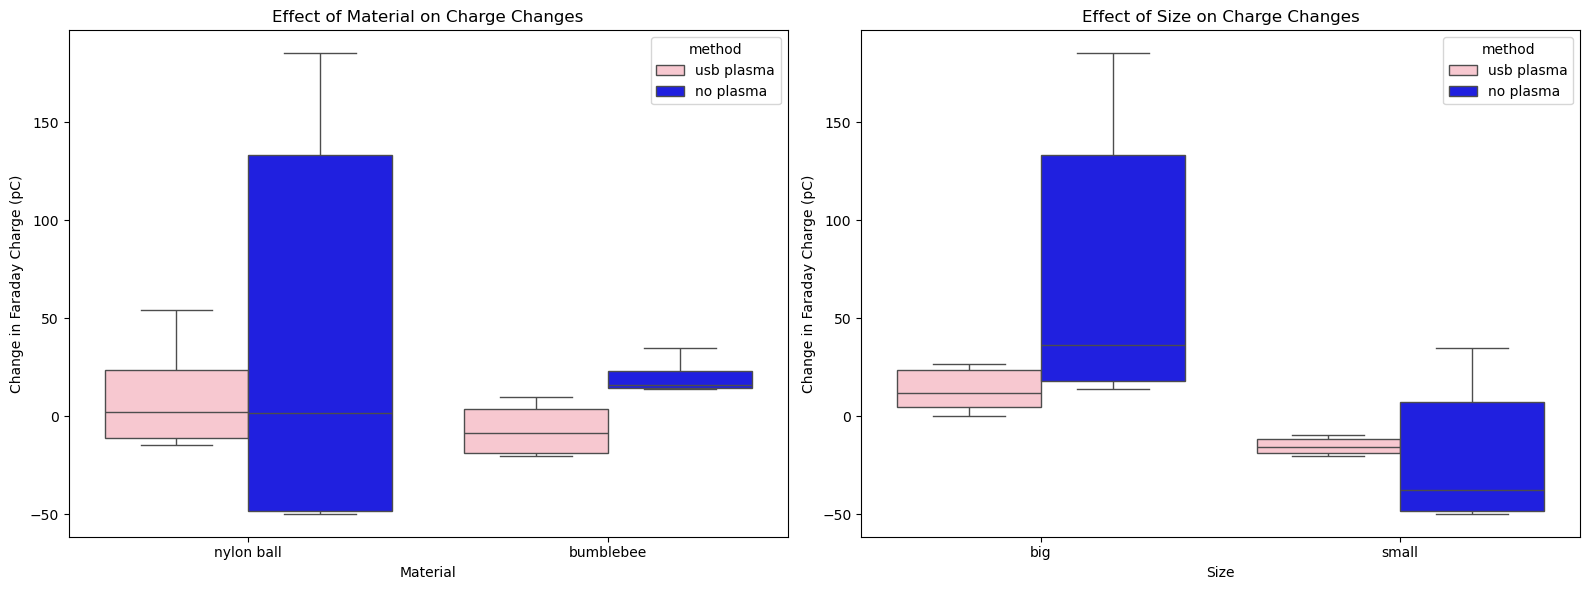

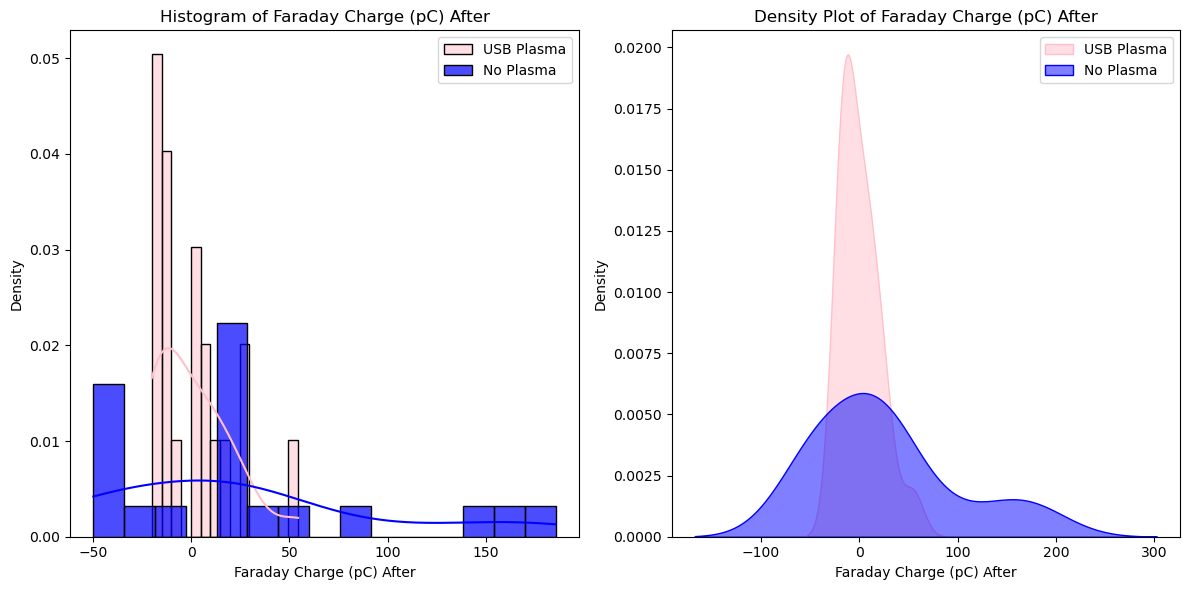

In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, shapiro
from scipy.stats import mannwhitneyu

# Load directly from GitHub
url = "https://raw.githubusercontent.com/yunaffx/rcs/main/USB_plasma_data.csv"
USBplasma = pd.read_csv(url)

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(USBplasma.head())

# I am using the Faraday charge measurements for this analysis, as they serve as the main metric for the below experiments. 
# The calibrated charge measurements from the custom-made RCS are complementary to these methods but are lightly less accurate.

# Start of first part of the code - Effectiveness of Charge Neutralization
# Q1: How close to zero are the charges after treatment?
# Purpose: Focus on the effectiveness of achieving charge neutrality directly.
# Logic: Closer to zero charges after treatment may indicate better neutralization, irrespective of the initial charge

# Summary statistics for Faraday Charge (pC) before and after
print("\
Summary statistics for Faraday Charge (pC) before and after:")
print(USBplasma[['faraday_charge_pC_before', 'faraday_charge_pC_after']].describe())

# Filter data by method
USBplasma_data = USBplasma[USBplasma['method'] == 'usb plasma']
no_USBplasma_data = USBplasma[USBplasma['method'] == 'no plasma']

# Shapiro-Wilk test for normality
shapiro_USBplasma = shapiro(USBplasma_data['faraday_charge_pC_after'])
shapiro_no_USBplasma = shapiro(no_USBplasma_data['faraday_charge_pC_after'])

print("\
Shapiro-Wilk Test Results:")
print("USB Plasma: W =", shapiro_USBplasma.statistic, ", p =", shapiro_USBplasma.pvalue)
print("No Plasma: W =", shapiro_no_USBplasma.statistic, ", p =", shapiro_no_USBplasma.pvalue)

# T-test to compare the two methods
t_stat, p_value = ttest_ind(USBplasma_data['faraday_charge_pC_after'], 
                           no_USBplasma_data['faraday_charge_pC_after'], 
                           equal_var=False)
print("\
T-Test Results:")
print("t-statistic =", t_stat, ", p-value =", p_value)

# Perform a non-parametric test since data is not normally distributed
# Mann-Whitney U test

# Extract the data for the two groups
usb_plasma_data = USBplasma[USBplasma['method'] == 'usb plasma']['faraday_charge_pC_after']
no_plasma_data = USBplasma[USBplasma['method'] == 'no plasma']['faraday_charge_pC_after']

# Mann-Whitney U test
mann_whitney_result = mannwhitneyu(usb_plasma_data, no_plasma_data, alternative='two-sided')

print("Mann-Whitney U Test Results:")
print("U-statistic =", mann_whitney_result.statistic, ", p-value =", mann_whitney_result.pvalue)

# Shapiro-Wilk Test Results:
# USB Plasma: W =0.8856, p = 0.0223
# No Plasma: W = 0.8586, p = 0.0074
# Both methods (usb plasma and no plasma) fail the normality test (p < 0.05), suggesting that the data is not normally distributed.
# T-Test Results (with caution):
# t-statistic = -1.524, p-value = 0.1417
# The t-test shows no significant difference between the means of faraday_charge_pC_after for the two methods (p = 0.1417).

# Mann-Whitney U Test Results:
# U-statistic = 161.0, p-value = 0.2977 (> 0.05)
# Since p > 0.05, we fail to reject the null hypothesis
# This suggests there is no statistically significant difference between the USB plasma and no plasma groups in terms of their faraday charge second measurements.

# Visualise everything
# Define the color palette
color_dict = {'usb plasma': 'pink', 'no plasma': 'blue'}

# Create side-by-side boxplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Scatterplot with regression lines - Relationship between Before and After Charges by Method (left)
for method, color in color_dict.items():
    subset = USBplasma[USBplasma['method'] == method]
    sns.regplot(
        data=subset,
        x='faraday_charge_pC_before',
        y='faraday_charge_pC_after',
        scatter_kws={'color': color, 's': 50},
        line_kws={'color': color},
        ci=None,
        ax=ax[0]
    )
ax[0].set_title('Relationship between Before and After Charges by Method')
ax[0].set_xlabel('Faraday Charge Before (pC)')
ax[0].set_ylabel('Faraday Charge After (pC)')
ax[0].legend(color_dict.keys(), title='Method')

# Boxplot - Comparison of Methods in Charge Neutralization (right)
sns.boxplot(
    x='method',
    y='faraday_charge_pC_after',
    data=USBplasma,
    hue='method',
    palette=color_dict,
    ax=ax[1]
)
ax[1].set_title('Comparison of Methods in Charge Neutralization')
ax[1].set_xlabel('Method')
ax[1].set_ylabel('Faraday Charge After (pC)')

# Legend explicitly for boxplot
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[:2], labels[:2], title='Method')

# Adjust layout and display
plt.tight_layout()
plt.show()


# Material-based analysis
materials = USBplasma['material'].unique()
plt.figure(figsize=(12, 6))

# Define axis limits for consistency
y_min, y_max = USBplasma['faraday_charge_pC_after'].min(), USBplasma['faraday_charge_pC_after'].max()
x_min, x_max = USBplasma['faraday_charge_pC_before'].min(), USBplasma['faraday_charge_pC_before'].max()
y_padding, x_padding = 10, 10

for idx, material in enumerate(materials, 1):
    plt.subplot(1, len(materials), idx)
    material_USBdata = USBplasma[USBplasma['material'] == material]
    sns.scatterplot(data=material_USBdata,
                    x='faraday_charge_pC_before',
                    y='faraday_charge_pC_after',
                    hue='method',
                    palette=color_dict)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    plt.ylim(y_min - y_padding, y_max + y_padding)
    plt.xlim(x_min - x_padding, x_max + x_padding)
    plt.title(material.capitalize())
    plt.xlabel('Initial Charge (pC)')
    plt.ylabel('Final Charge (pC)')

plt.tight_layout()
plt.show()

# Effectiveness by size
USBplasma['size'] = USBplasma['size'].str.strip().str.lower()
size_effect_summary = USBplasma.groupby(['size', 'method']).agg(
    mean_faraday_change=('faraday_charge_pC_after', 'mean'),
    sd_faraday_change=('faraday_charge_pC_after', 'std'),
    n=('faraday_charge_pC_after', 'count')
).reset_index().round(2)

print("\
Summary of size effect on charge changes:")
print(size_effect_summary)

# Effectiveness by material
USBplasma['material'] = USBplasma['material'].str.strip().str.lower()
material_effect_summary = USBplasma.groupby(['material', 'method']).agg(
    mean_faraday_change=('faraday_charge_pC_after', 'mean'),
    sd_faraday_change=('faraday_charge_pC_after', 'std'),
    n=('faraday_charge_pC_after', 'count')
).reset_index().round(2)

print("\
Summary of material effect on charge changes:")
print(material_effect_summary)

# Create side-by-side boxplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot - Effect of Material on Charge Changes(left)
sns.boxplot(
    data=USBplasma,
    x='material',
    y='faraday_charge_pC_after',
    hue='method',
    palette=color_dict,
    ax=ax[0],
    showfliers=False
)
ax[0].set_title('Effect of Material on Charge Changes')
ax[0].set_xlabel('Material')
ax[0].set_ylabel('Change in Faraday Charge (pC)')

# Boxplot - Effect of Size on Charge Changes (right)
sns.boxplot(
    data=USBplasma,
    x='size', 
    y='faraday_charge_pC_after',
    hue='method',
    palette=color_dict,
    ax=ax[1],
    showfliers=False
)
ax[1].set_title('Effect of Size on Charge Changes')
ax[1].set_xlabel('Size')
ax[1].set_ylabel('Change in Faraday Charge (pC)')

plt.tight_layout()
plt.show()

# Create side-by-side boxplots
plt.figure(figsize=(12, 6))

# Histogram of Faraday Charge (pC) After (left)
plt.subplot(1, 2, 1)
sns.histplot(usb_plasma_data, color='pink', label='USB Plasma', kde=True, bins=15, stat="density")
sns.histplot(no_plasma_data, color='blue', label='No Plasma', kde=True, bins=15, stat="density", alpha=0.7)
plt.title('Histogram of Faraday Charge (pC) After')
plt.xlabel('Faraday Charge (pC) After')
plt.ylabel('Density')
plt.legend()

# Density Plot of Faraday Charge (pC) After (right)
plt.subplot(1, 2, 2)
sns.kdeplot(usb_plasma_data, color='pink', label='USB Plasma', fill=True, alpha=0.5)
sns.kdeplot(no_plasma_data, color='blue', label='No Plasma', fill=True, alpha=0.5)
plt.title('Density Plot of Faraday Charge (pC) After')
plt.xlabel('Faraday Charge (pC) After')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# End of first part of the code - Effectiveness of Charge Neutralization

Mann-Whitney U Test Results for Magnitude of Change:
U-statistic = 301.0
p-value = 0.006557192645280169
Descriptive Statistics for Charge Changes:
USB Plasma Treatment:
count     20.000000
mean     108.509100
std       73.902683
min       17.040000
25%       46.360250
50%       67.698500
75%      169.307500
max      251.120000
Name: charge_change, dtype: float64
No Plasma Treatment:
count     20.000000
mean      56.435100
std       46.180253
min       13.980000
25%       20.350000
50%       36.350000
75%       86.525000
max      164.250000
Name: charge_change, dtype: float64


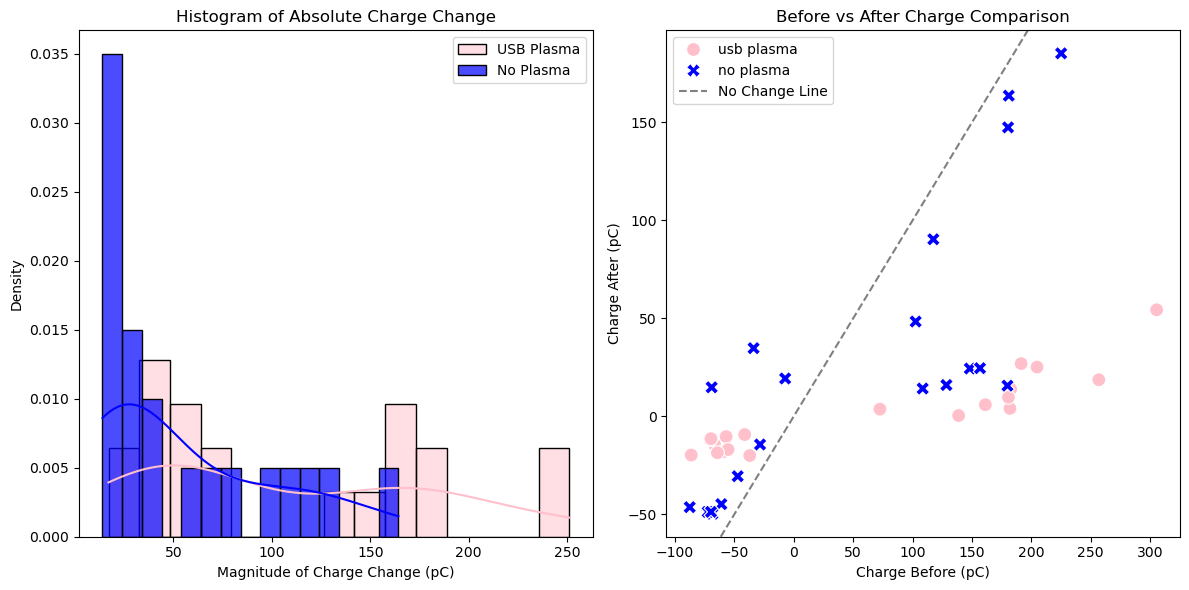

Descriptive Statistics for Charge Changes by Size and Method:
                  count      mean        std     min       25%       50%  \
size  method                                                               
big   no plasma    10.0   79.8470  51.891700  17.300   34.6250   74.2650   
      usb plasma   10.0  171.3817  50.367341  68.867  157.6620  169.8750   
small no plasma    10.0   33.0232  24.318765  13.980   17.1325   22.2550   
      usb plasma   10.0   45.6365  14.450782  17.040   39.1425   46.1435   

                        75%     max  
size  method                         
big   no plasma   120.99000  164.25  
      usb plasma  179.23175  251.12  
small no plasma    37.52300   83.93  
      usb plasma   56.66750   66.53  
Mann-Whitney U Test Results by Size:
Big Size - U-statistic = 93.0 , p-value = 0.0013149446697132139
Small Size - U-statistic = 73.0 , p-value = 0.08897301170181328


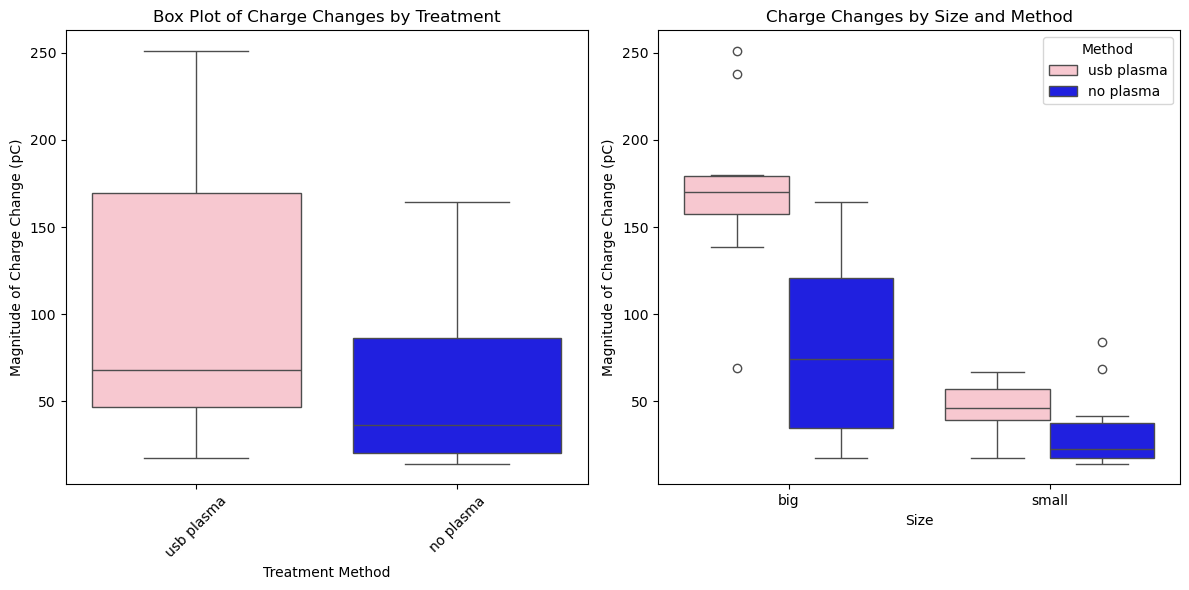

In [11]:
# Import required libraries
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

# Start of second part of the code - Magnitude of Charge Change
# How much change occurred due to the treatment?
# Purpose: Measure the magnitude of the change in charge, whether positive or negative.
# Logic: Evaluate how much the plasma treatment adjusts the charge compared to no plasma, without focusing exclusively on neutrality.

# Calculate the absolute change in charge
USBplasma['charge_change'] = abs(USBplasma['faraday_charge_pC_after'] - USBplasma['faraday_charge_pC_before'])

# Extract the data for the two groups
usb_plasma_change = USBplasma[USBplasma['method'] == 'usb plasma']['charge_change']
no_plasma_change = USBplasma[USBplasma['method'] == 'no plasma']['charge_change']

# Mann-Whitney U test on the charge changes
mann_whitney_result = mannwhitneyu(usb_plasma_change, no_plasma_change, alternative='two-sided')

print("Mann-Whitney U Test Results for Magnitude of Change:")
print("U-statistic =", mann_whitney_result.statistic)
print("p-value =", mann_whitney_result.pvalue)

# Descriptive statistics for each group
print("\
Descriptive Statistics for Charge Changes:")
print("\
USB Plasma Treatment:")
print(usb_plasma_change.describe())
print("\
No Plasma Treatment:")
print(no_plasma_change.describe())


# Create side-by-side boxplots
plt.figure(figsize=(12, 6))

# Histogram - Absolute Charge Change (left)
plt.subplot(1, 2, 1)
sns.histplot(usb_plasma_change, color='pink', label='USB Plasma', kde=True, bins=15, stat="density")
sns.histplot(no_plasma_change, color='blue', label='No Plasma', kde=True, bins=15, stat="density", alpha=0.7)
plt.title('Histogram of Absolute Charge Change')
plt.xlabel('Magnitude of Charge Change (pC)')
plt.ylabel('Density')
plt.legend()

# Scatter plot - Before vs After Charge Comparison (right)
plt.subplot(1, 2, 2)
sns.scatterplot(data=USBplasma, 
                x='faraday_charge_pC_before', 
                y='faraday_charge_pC_after', 
                style='method', s=100,
                hue='method',
                palette=color_dict)
plt.axline([0, 0], [1, 1], color='gray', linestyle='--', label='No Change Line')
plt.title('Before vs After Charge Comparison')
plt.xlabel('Charge Before (pC)')
plt.ylabel('Charge After (pC)')
plt.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


# Analyze the effect of size on charge changes
# Group data by size and method
size_grouped = USBplasma.groupby(['size', 'method'])['charge_change']

# Ddescriptive statistics for each group
size_stats = size_grouped.describe()
print("\
Descriptive Statistics for Charge Changes by Size and Method:")
print(size_stats)

# Mann-Whitney U test for each size group
big_usb_plasma = USBplasma[(USBplasma['size'] == 'big') & (USBplasma['method'] == 'usb plasma')]['charge_change']
big_no_plasma = USBplasma[(USBplasma['size'] == 'big') & (USBplasma['method'] == 'no plasma')]['charge_change']
small_usb_plasma = USBplasma[(USBplasma['size'] == 'small') & (USBplasma['method'] == 'usb plasma')]['charge_change']
small_no_plasma = USBplasma[(USBplasma['size'] == 'small') & (USBplasma['method'] == 'no plasma')]['charge_change']

# Mann-Whitney U tests
big_test = mannwhitneyu(big_usb_plasma, big_no_plasma, alternative='two-sided')
small_test = mannwhitneyu(small_usb_plasma, small_no_plasma, alternative='two-sided')

print("\
Mann-Whitney U Test Results by Size:")
print("Big Size - U-statistic =", big_test.statistic, ", p-value =", big_test.pvalue)
print("Small Size - U-statistic =", small_test.statistic, ", p-value =", small_test.pvalue)


# Create side-by-side boxplots
plt.figure(figsize=(12, 6))

# Boxplot - Charge Changes by Treatment Method (left)
plt.subplot(1, 2, 1)
sns.boxplot(data=USBplasma,
            x='method', 
            y='charge_change',
            hue='method',
            palette=color_dict)
plt.title('Box Plot of Charge Changes by Treatment')
plt.xlabel('Treatment Method')
plt.ylabel('Magnitude of Charge Change (pC)')
plt.xticks(rotation=45)

# Boxplot - Charge Changes by Size and Method (right)
plt.subplot(1, 2, 2)
sns.boxplot(data=USBplasma,
            x='size', 
            y='charge_change',
            hue='method',
            palette=color_dict)
plt.title('Charge Changes by Size and Method')
plt.xlabel('Size')
plt.ylabel('Magnitude of Charge Change (pC)')
plt.legend(title='Method')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

# Mann-Whitney U Test Results by Size:
# Big Size - U-statistic = 93.0, p-value = 0.001315
# Small Size - U-statistic = 73.0, p-value = 0.08897

# Key Observations:
# Big Size:
# USB plasma treatment shows significantly larger charge changes compared to no plasma (p < 0.05).
# Mean charge change for USB plasma is much higher than for no plasma.
# Small Size:
# The difference in charge changes between USB plasma and no plasma is not statistically significant (p > 0.05).
# The variability in charge changes is lower for small sizes compared to big sizes.

# End of second part of the code - Magnitude of Charge Change
